## Random Forest Model

In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.inspection import PartialDependenceDisplay

First we import the 2010 and 2020 dataset created in these notebooks: 2010 and 2020

In [2]:
# read in data
parceldata_10=pd.read_csv('data/all_data_joined_2010.csv')

# need to set APN to be index so that we can join this back to other information later on
parceldata_10.set_index('APN',inplace=True)
parceldata_10.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/all_data_joined_2010.csv'

In [3]:
# Create a dataset for data as of 2020
parceldata_20=pd.read_csv('data/all_data_joined_2020.csv')

# need to set APN to be index so that we can join this back to other information later on
parceldata_20.set_index('APN',inplace=True)
parceldata_20.head()

C:\Users\Monisha\AppData\Local\Temp\ipykernel_38016\1273726340.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  parceldata_20=pd.read_csv('data/all_data_joined_2020.csv')


,GEO_ID,LAND_VALUE,distances,building_class,year,acres,sqft,num_warehouses,warehouse_start,buit_within_decade,...,Total Workers,Percent Employee of private company workers,Percent Self-employed in own incorporated business workers,Percent Private not-for-profit wage and salary workers,Percent Local government workers,Percent State government workers,Percent Federal government workers,Percent Self-employed in own not incorporated business workers,Percent Unpaid family workers,geometry_census
APN,,,,,,,,,,,,,,,,,,,,,
210080008.0,6.065030e+09,415583.0,1276.949816,NaN,NaN,NaN,NaN,0.0,0,0,...,571.0,78.458844,2.802102,7.180385,6.830123,1.050788,0.0,3.677758,0.0,"POLYGON ((-13064177.03 4027912.35, -13064167.1..."
210060035.0,6.065030e+09,0.0,1448.959298,NaN,NaN,NaN,NaN,0.0,0,0,...,571.0,78.458844,2.802102,7.180385,6.830123,1.050788,0.0,3.677758,0.0,"POLYGON ((-13064177.03 4027912.35, -13064167.1..."
210210051.0,6.065030e+09,154517.0,960.746466,NaN,NaN,NaN,NaN,0.0,0,0,...,571.0,78.458844,2.802102,7.180385,6.830123,1.050788,0.0,3.677758,0.0,"POLYGON ((-13064177.03 4027912.35, -13064167.1..."
210210076.0,6.065030e+09,0.0,885.698095,NaN,NaN,NaN,NaN,0.0,0,0,...,571.0,78.458844,2.802102,7.180385,6.830123,1.050788,0.0,3.677758,0.0,"POLYGON ((-13064177.03 4027912.35, -13064167.1..."
210210046.0,6.065030e+09,73581.0,852.249225,NaN,NaN,NaN,NaN,0.0,0,0,...,571.0,78.458844,2.802102,7.180385,6.830123,1.050788,0.0,3.677758,0.0,"POLYGON ((-13064177.03 4027912.35, -13064167.1..."


### Train Random Forest Model with 2010 Dataset

Here we set up the training model by specifying the x and y variables to use and creating a train/test split

In [4]:
# define variables 
cols=parceldata_10.columns.to_list()
xvars=[col for col in cols if col not in ('APN','building_class','year','acres','sqft','num_warehouses','buit_within_decade',
                                          'geometry','PID19','APN19','CITY','COUNTY','LU19','LU16','JURISDICTI','LU19_CLASS','SCAG_ZN_CO','Shape_Leng','Shape_Area',
                                          'GEO_ID','state_x','county_x','tract_x','NAME','tract_y_x','tract','tract_y_y','geometry_census')]
yvar = 'buit_within_decade'

# create a dataframe with no NaNs
parceldata_10_model = parceldata_10[xvars+[yvar]].dropna()

# create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    parceldata_10_model[xvars], parceldata_10_model[yvar], test_size = 0.25, random_state = 1)

Now we run the model and use it to make predictions with the test dataset

In [5]:
# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# fit the model
rf.fit(X_train, y_train)

# apply predictions to test dataset
y_pred = rf.predict(X_test)

In [6]:
# stop if the length of the predictions doesn't match the training dataset
assert len(X_test)==len(y_pred)

We used a Confusion Matrix for an initial assessment of performance

Predicted fraction True: 0.0001. Actual fraction True: 0.0003


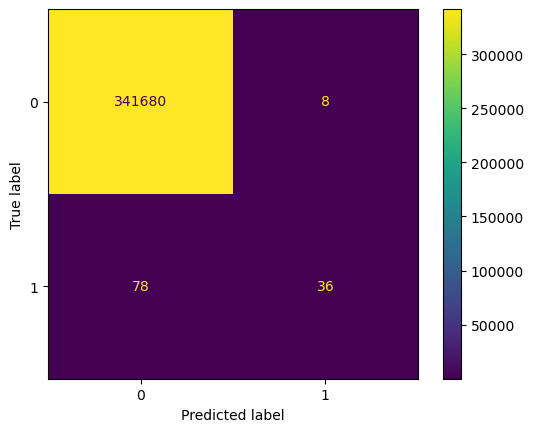

In [7]:
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

We used the feature importances to identify variables worth looking into further

Text(0, 0.5, 'Mean decrease in impurity')

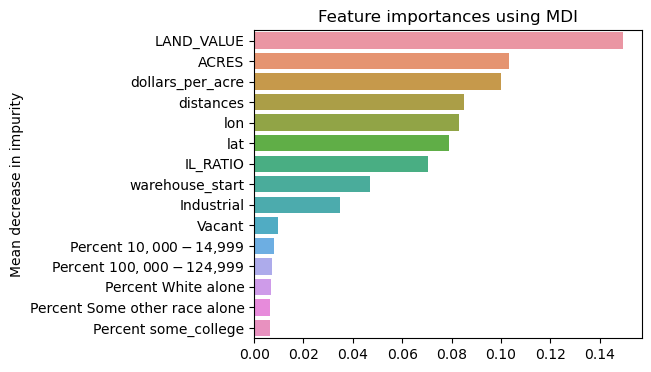

In [8]:
# create series of importances
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances.sort_values(inplace=True, ascending=False)

# plot them
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(x=forest_importances[:20].values, y=forest_importances[:15].index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### Apply Model to 2020 Dataset

In [9]:
# define variables 
cols=parceldata_20.columns.to_list()
xvars=[col for col in cols if col not in ('APN','building_class','year','acres','sqft','num_warehouses','buit_within_decade',
                                          'geometry','PID19','APN19','CITY','COUNTY','LU19','LU16','JURISDICTI','LU19_CLASS','SCAG_ZN_CO','Shape_Leng','Shape_Area',
                                          'GEO_ID','state_x','county_x','tract_x','NAME','tract_y_x','tract','tract_y_y','geometry_census')]
yvar = 'buit_within_decade'

# create a dataframe with no NaNs
parceldata_20_model = parceldata_20[xvars+[yvar]].dropna()

We now use the same RF model from before to predict the percent chance that a warehouse will be built within a decade on the 2020 data

In [10]:
# apply predictions from previous model to test dataset
X_test=parceldata_20_model[xvars]
y_pred = rf.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- county
- state
Feature names seen at fit time, yet now missing:
- Total:


In [ ]:
# stop if lengths don't match
assert len(X_test)==len(y_pred)
# how many does it predict?
print('Predicted fraction True: {:.4f}'.format(y_pred.mean()))
print('Predicted number True: {:.0f}'.format(y_pred.sum()))

We will now create a dataframe of predictions to be able to visualize the results

In [ ]:
# create a dataframe of predictions about whether or not a parcel will have a warehouse built on it within 10 years & join this to the full df
predictions = pd.DataFrame(rf.predict_proba(X_test),columns = ['pred_noWH', 'pred_WH'])
predictions= predictions.join((X_test).reset_index())
predictions.set_index('APN',inplace=True)
predictions.head()

In [ ]:
# not a whole lot actally predicted to become warehouses... maybe visualize percentages above a certain point if census data doesn't fix
print(len(predictions[predictions.pred_WH>0.5]))
print(len(predictions[predictions.pred_WH>0.25]))

In [ ]:
# save her!!!!
predictions.to_csv('predictions.csv')